In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Generate from Folders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# DATA AUGMENTATION via Generator

batch_size = 64
train_input_shape = (224, 224, 3)
n_classes = 50
print(n_classes)

shared = "drive/MyDrive/Proj_4/"
trainFolder = shared + "all/train/"
valFolder = shared + "all/val/"

train_datagen = ImageDataGenerator(
                                   rescale=1./255.,
                                   #rotation_range=30,
                                   #zoom_range=0.5,
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

val_datagen = ImageDataGenerator(
                                   rescale=1./255.,
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=trainFolder,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                   )

valid_generator = val_datagen.flow_from_directory(directory=valFolder,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

50
Found 6706 images belonging to 50 classes.
Found 1649 images belonging to 50 classes.
Total number of batches = 104 and 25


In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Disable GPU usage

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4456680209868248955
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1313989391019439850
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
#from tensorflow_addons.metrics import F1Score


class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)



Metrics = ["acc","Precision", "Recall", F1_Score()]


def FCN3(base, dense1, dense2):
    MY_SIZE = 224
    IMG_SIZE = (MY_SIZE,MY_SIZE)
    IMG_SHAPE = IMG_SIZE + (3,)

    model = tf.keras.Sequential([
        base.layers[0],
        base.layers[1],
        
        layers.Dense(dense1, activation="relu"),
        layers.Dropout(.5),
        layers.BatchNormalization(),
        
        layers.Dense(dense2, activation="relu"),
        layers.Dropout(.5),
        layers.BatchNormalization(),
        
        layers.Dense(n_classes, activation = "softmax"),   
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
        loss='categorical_crossentropy',
        metrics=Metrics)
    return model

In [ ]:
baseModelPath = shared + "myBaseModel.h5"
dense1 = 448
dense2 = 160
base = tf.keras.models.load_model(baseModelPath, custom_objects={"F1_Score": F1_Score})

# Freeze Reznet
base.trainable = False

myModel = FCN3(base ,dense1, dense2)
myModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 448)               917952    
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 batch_normalization (BatchN  (None, 448)              1792      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 160)               7

In [ ]:
# Create and Fit Model

import matplotlib.pyplot as plt

outModelPath = shared + "last_model" + ".h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=9,restore_best_weights=False, mode="max", verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_score', factor=0.1,patience=4, 
                              verbose=1, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    outModelPath, monitor='val_f1_score', verbose=1, save_best_only=True,
    save_weights_only=False, mode='max', save_freq='epoch',
    options=None)

history = myModel.fit(train_generator, validation_data = valid_generator, epochs=40, verbose = 1,
                      callbacks=[earlystopping, reduce_lr, checkpoint])


Epoch 1/40
105/105 [==============================] - ETA: 0s - loss: 3.4471 - acc: 0.1806 - precision: 0.7455 - recall: 0.0245 - f1_score: 0.0474  
Epoch 00001: val_f1_score improved from -inf to 0.18482, saving model to drive/MyDrive/Proj_4/last_model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


105/105 [==============================] - 9360s 89s/step - loss: 3.4471 - acc: 0.1806 - precision: 0.7455 - recall: 0.0245 - f1_score: 0.0474 - val_loss: 2.3442 - val_acc: 0.5979 - val_precision: 0.9941 - val_recall: 0.1019 - val_f1_score: 0.1848 - lr: 1.0000e-04
Epoch 2/40
105/105 [==============================] - ETA: 0s - loss: 2.1909 - acc: 0.4922 - precision: 0.9527 - recall: 0.1682 - f1_score: 0.2859
Epoch 00002: val_f1_score improved from 0.18482 to 0.39324, saving model to drive/MyDrive/Proj_4/last_model.h5
105/105 [==============================] - 91s 870ms/step - loss: 2.1909 - acc: 0.4922 - precision: 0.9527 - recall: 0.1682 - f1_score: 0.2859 - val_loss: 1.8373 - val_acc: 0.6847 - val_precision: 0.9667 - val_recall: 0.2468 - val_f1_score: 0.3932 - lr: 1.0000e-04
Epoch 3/40
105/105 [==============================] - ETA: 0s - loss: 1.6512 - acc: 0.6525 - precision: 0.9729 - recall: 0.2942 - f1_score: 0.4518
Epoch 00003: val_f1_score improved from 0.39324 to 0.49369, savin

In [ ]:
results = myModel.evaluate(valid_generator) 
print(results)

26/26 [==============================] - 17s 668ms/step - loss: 0.7914 - acc: 0.8047 - precision: 0.8812 - recall: 0.7599 - f1_score: 0.8160
[0.791389524936676, 0.8047301173210144, 0.8811532855033875, 0.7598544359207153, 0.8160203099250793]


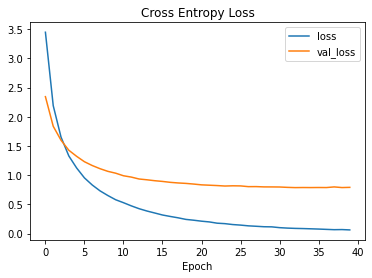

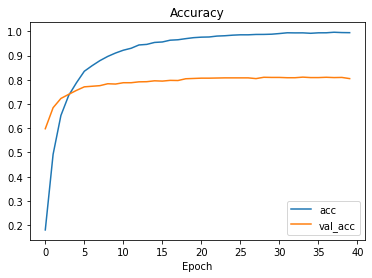

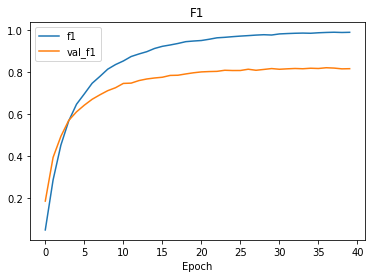

In [ ]:
def plot_loss(history, lossOnly=False):
    plt.figure()
    plt.title("Cross Entropy Loss")
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.figure()
    plt.title("Accuracy")
    plt.plot(history.history['acc'], label='acc')
    plt.plot(history.history['val_acc'], label='val_acc')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.figure()
    plt.title("F1")
    plt.plot(history.history['f1_score'], label='f1')
    plt.plot(history.history['val_f1_score'], label='val_f1')
    plt.xlabel('Epoch')
    plt.legend()

plot_loss(history)

In [ ]:
# Unfreeze Reznet for fine-tuning
base.trainable = True
myModel.summary()

myModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7), 
        loss='categorical_crossentropy',
        metrics=Metrics)

history = myModel.fit(train_generator, validation_data = valid_generator, epochs=40, verbose = 1,
                      callbacks=[earlystopping, reduce_lr, checkpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 448)               917952    
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 batch_normalization (BatchN  (None, 448)              1792      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 160)               7

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


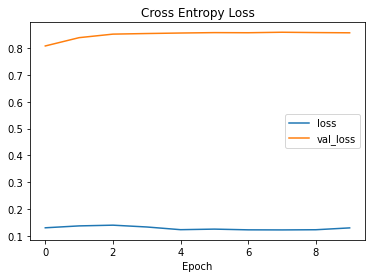

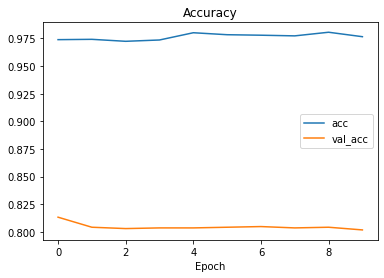

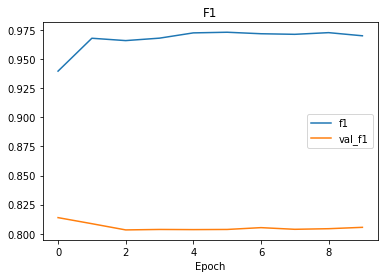

In [ ]:
plot_loss(history)

tf.keras.models.save_model(myModel, shared + "transfer.h5")

In [ ]:
base = tf.keras.models.load_model(baseModelPath, custom_objects={"F1_Score": F1_Score})
results = base.evaluate(valid_generator) 
print(results)

26/26 [==============================] - 19s 689ms/step - loss: 1.0307 - acc: 0.7787 - precision: 0.8140 - recall: 0.7641 - f1_score: 0.7882
[1.0307446718215942, 0.7786537408828735, 0.8139534592628479, 0.7640994787216187, 0.7882384061813354]
